In [9]:
# get data minimum 140 and cuts excess

import os
import pandas as pd

folder_path = "abide_timeseries/aal_csv"  # replace this with cc200 depends

valid_dfs = []  

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        try:
            df = pd.read_csv(file_path)
            df = df.drop(index=0).reset_index(drop=True) # skip second row since metadata
            
            if len(df) >= 140:
                trimmed_df = df.iloc[:140]  # keep only first 140 rows
                valid_dfs.append(trimmed_df)
        except Exception as e:
            print(f"Error reading {filename}: {e}")

print("finished cutting")

finished cutting


In [10]:
# sliding window slice - 40 length, 10 step, 11 total slices
# store slice per person as 2d arr
subject_windows = []

for df in valid_dfs:
    windows = []
    for start in range(0, 140 - 40 + 1, 10):
        window = df.iloc[start:start + 40].copy()
        windows.append(window)
    subject_windows.append(windows)

# visualization
for i, window in enumerate(subject_windows[0]):
    print(f"--- Window {i+1} ---")
    print(window)
    print()

--- Window 1 ---
             0           1           2           3          4          5  \
0    -2.539332    2.747596    1.182977    2.538651   1.886804   4.915048   
1    -2.321754   -0.034424    1.901878    2.098236   2.484421   4.541738   
2    -0.643494   -3.851515    0.935755   -0.919723   1.869644    3.12976   
3     2.144931   -4.198091   -1.795584   -5.477897   0.075232   1.585569   
4     4.156425   -0.088777   -4.401994   -8.703161  -1.889188   0.134632   
5     3.556201    4.856087   -4.591857    -8.18452  -2.648489  -1.415816   
6     0.729206    6.625133   -2.079485   -4.268152  -1.621277  -2.857548   
7    -1.633136    5.109288    0.972806    0.244161   0.367065   -3.47564   
8     -1.09179    3.435546    2.198986    2.906426   1.769928  -2.841991   
9     2.011754    3.685199    1.478088    3.929358   1.738137  -1.407874   
10    5.002143    4.658591    0.746029    5.369237    0.81626   -0.06776   
11    5.830677    4.248411     1.42956    8.156937   0.148851   0.71467

            0         1         2         3         4         5         6  \
0    1.000000  0.582141  0.337066 -0.031667  0.179502  0.034498  0.504358   
1    0.582141  1.000000  0.211456  0.461203  0.123911  0.238322  0.440272   
2    0.337066  0.211456  1.000000  0.186156  0.841299  0.508014  0.691809   
3   -0.031667  0.461203  0.186156  1.000000  0.187659  0.506623  0.476033   
4    0.179502  0.123911  0.841299  0.187659  1.000000  0.550402  0.447890   
..        ...       ...       ...       ...       ...       ...       ...   
111 -0.194683 -0.103641 -0.558726 -0.154536 -0.513912 -0.743286 -0.387927   
112  0.045630  0.139025  0.320212 -0.114963  0.359960 -0.183294  0.174899   
113 -0.043375  0.194414  0.080072 -0.249028  0.171270 -0.185735  0.002836   
114 -0.230944  0.070319  0.205253 -0.187602  0.344717 -0.160852 -0.116647   
115 -0.024256  0.126749  0.253585 -0.142115  0.325675 -0.191671  0.087346   

            7         8         9  ...       106       107       108  \
0  

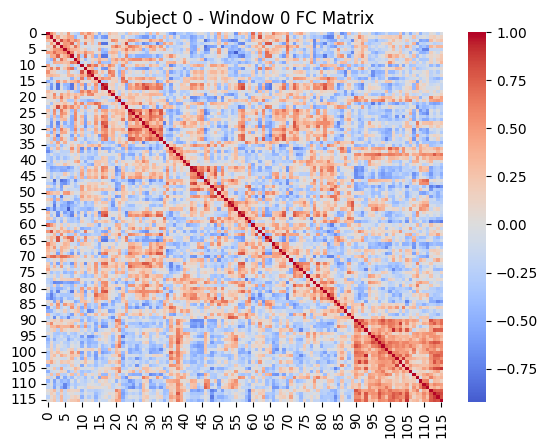

In [11]:
# compute FC matrix per slice with zero connectivity assumption
import matplotlib.pyplot as plt
import seaborn as sns  

subject_fc_matrices = []  # [subject][window] 

for subject in subject_windows:
    subject_fc = []
    for window_df in subject:
        # Compute correlation matrix
        fc_matrix = window_df.corr(method='pearson')  # Pearson correlation matrix (FC matrix)
        
        # Handle NaN values: Replace with 0 (zero connectivity assumption)
        # This represents "no functional connectivity" for problematic regions
        fc_matrix = fc_matrix.fillna(0)
        
        subject_fc.append(fc_matrix)
    subject_fc_matrices.append(subject_fc)

# print first fc window of first subject
print(subject_fc_matrices[0][0])

# Visualize FC matrix of subject 0, window 0
sns.heatmap(subject_fc_matrices[0][0], cmap='coolwarm', center=0)
plt.title("Subject 0 - Window 0 FC Matrix")
plt.show()

## NaN Handling Summary and Research Guidelines

### What We Implemented:

1. **Subject Group Identification**: Automatically categorized subjects into ASD, Control, Mixed, or Unknown groups based on ABIDE site naming patterns.

2. **Comprehensive NaN Tracking**: 
   - Track NaN occurrences before and after correlation computation
   - Identify zero-variance brain regions per subject
   - Calculate NaN percentages and window-level statistics

3. **Zero Connectivity Assumption**: 
   - Replace all NaN correlations with 0 (representing no functional connectivity)
   - This is neurobiologically reasonable for brain networks

### Key Features:
- **Group-wise analysis**: Compare NaN rates between ASD and control groups
- **Statistical testing**: T-test to detect significant differences in data quality
- **Regional analysis**: Identify problematic brain regions
- **Quality control metrics**: Export detailed statistics for further analysis

### Next Steps for Your Research:

1. **Review the exported CSV** (`nan_analysis_results.csv`) to identify subjects with high NaN rates
2. **Consider excluding subjects** with >10% NaN rates for cleaner analysis
3. **Document any group differences** in NaN rates in your thesis methodology
4. **Use this information** to justify your preprocessing decisions

### Important Notes:
- The group assignments are based on typical ABIDE patterns but should be verified with official phenotype data
- Zero connectivity assumption is standard practice in neuroimaging
- NaN tracking helps ensure reproducible and transparent preprocessing


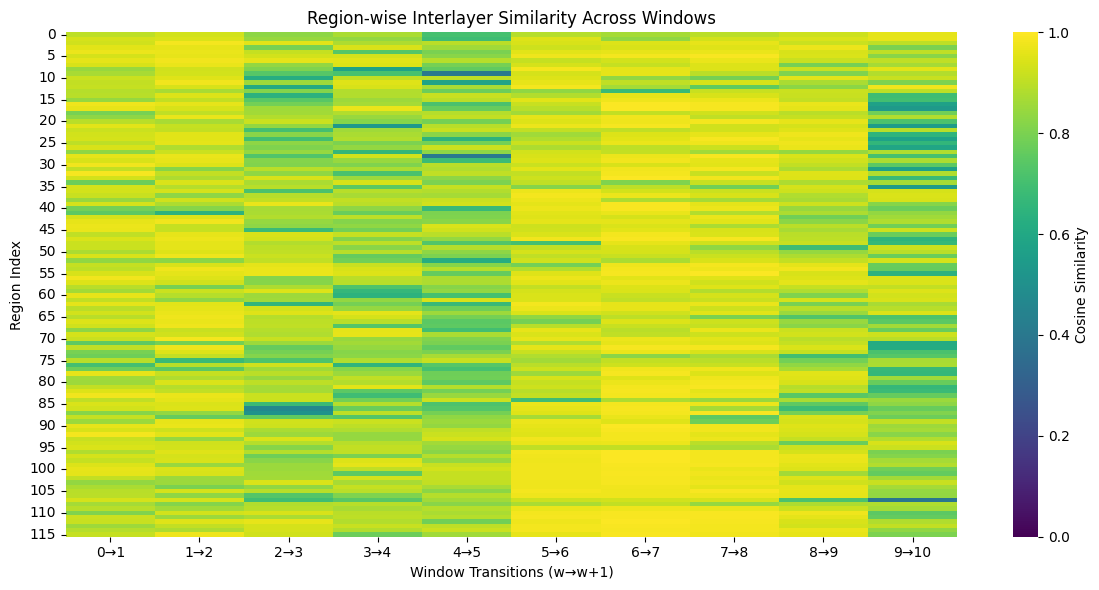

In [13]:
%matplotlib inline
# adjacency matrix for INTERLAYER connections

# notes abt this -> sa pag gawa nung weights may overlap ung FC matrices kasi nga sliding window so FC 1 is timestep 0-40 
# tapos FC 2 is timestep 10-50 kaya mataas ung correlation almost all of the time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def build_interlayer_adjacency(fc_matrices_subject):
    """
    Build interlayer adjacency matrix with consistent NaN handling.
    FC matrices are already processed (NaNs replaced with 0) from previous step.
    """
    numWindows = len(fc_matrices_subject)
    numRegions = fc_matrices_subject[0].shape[0]
    
    # init output matrix: rows = window transitions, columns = regions
    adj_matrix = np.zeros((numWindows - 1, numRegions))

    for w in range(numWindows - 1):
        # FC matrices already have NaNs handled (replaced with 0)
        fc1 = fc_matrices_subject[w]
        fc2 = fc_matrices_subject[w + 1]

        for r in range(numRegions):
            vec1 = fc1.iloc[r, :].values
            vec2 = fc2.iloc[r, :].values

            # Additional safety check for any remaining NaNs or low variance
            if np.isnan(vec1).any() or np.isnan(vec2).any():
                weight = 0
            elif np.std(vec1) < 1e-10 or np.std(vec2) < 1e-10:
                weight = 0  # Zero connectivity for low variance regions
            else:
                corr = np.corrcoef(vec1, vec2)[0, 1]
                weight = corr if not np.isnan(corr) else 0

            adj_matrix[w, r] = weight

    return adj_matrix

interlayer_adjacency_matrices = []

for s in subject_fc_matrices:
    adj = build_interlayer_adjacency(s)
    interlayer_adjacency_matrices.append(adj)

# visualization
adj = interlayer_adjacency_matrices[0]  # subject 0

def plot_interlayer_similarity_matrix(matrix, use_cosine=True):
    transposed = matrix.T  # transpose kasi baliktas ung output ng build

    plt.figure(figsize=(12, 6))
    sns.heatmap(transposed, cmap='viridis', vmin=0, vmax=1,
                xticklabels=[f'{i}→{i+1}' for i in range(transposed.shape[1])],
                yticklabels=5,
                cbar_kws={'label': 'Cosine Similarity' if use_cosine else 'Correlation'})
    
    plt.title("Region-wise Interlayer Similarity Across Windows")
    plt.xlabel("Window Transitions (w→w+1)")
    plt.ylabel("Region Index")
    plt.tight_layout()
    plt.show()

plot_interlayer_similarity_matrix(adj)

In [ ]:
# import numpy as np
# import pandas as pd
# import os

# def export_fc_to_csv(subject_fc_matrices, output_dir="fc_exports"):
#     second_subject_fc = np.array(subject_fc_matrices[1])  # Subject 2
#     num_windows = second_subject_fc.shape[0]

#     # Create output folder if it doesn't exist
#     os.makedirs(output_dir, exist_ok=True)

#     for w in range(num_windows):
#         fc_matrix = second_subject_fc[w]
#         df = pd.DataFrame(fc_matrix)
#         csv_path = os.path.join(output_dir, f"fc_window_{w}.csv")
#         df.to_csv(csv_path, index=False, header=False)
#         print(f"Saved: {csv_path}")

# export_fc_to_csv(subject_fc_matrices)

PermissionError: [Errno 13] Permission denied: 'fc_exports\\fc_window_0.csv'

In [14]:
import numpy as np

NUM_OF_NODES = 116

print(subject_fc_matrices[1])

def inspect_second_subject(subject_fc_matrices):
    second_subject_fc = np.array(subject_fc_matrices[1])  # Subject 2
    num_windows = second_subject_fc.shape[0]

    print(f"Second subject has {num_windows} FC matrices (windows).\n")

    for w in range(num_windows):
        fc_matrix = second_subject_fc[w]
        print(f"\n--- FC Matrix for Window {w} ---")
        print(fc_matrix)

        # Check for NaNs in this matrix
        nan_indices = np.argwhere(np.isnan(fc_matrix))
        if nan_indices.size > 0:
            print(f"⚠️  NaNs found in Window {w}:")
            for (i, j) in nan_indices:
                print(f"  - NaN at row {i}, column {j}")
        else:
            print("✅ No NaNs in this window.")

inspect_second_subject(subject_fc_matrices)

[            0         1         2         3         4         5         6  \
0    1.000000  0.291462 -0.634883 -0.122771 -0.014615 -0.479513 -0.386889   
1    0.291462  1.000000 -0.270657  0.203667  0.056676  0.043558  0.078655   
2   -0.634883 -0.270657  1.000000 -0.311193  0.319560  0.191088  0.822949   
3   -0.122771  0.203667 -0.311193  1.000000 -0.354783  0.434252 -0.384271   
4   -0.014615  0.056676  0.319560 -0.354783  1.000000 -0.320989  0.513613   
..        ...       ...       ...       ...       ...       ...       ...   
111 -0.482971 -0.485309  0.287528 -0.044314 -0.333636  0.103280 -0.120441   
112 -0.589409  0.088574  0.379688  0.227141 -0.037308  0.569914  0.263607   
113 -0.277837 -0.241686  0.162585 -0.172157  0.026988  0.204313  0.055944   
114 -0.552607  0.024232  0.367530 -0.189707  0.361439  0.165689  0.343800   
115 -0.325821  0.318295  0.166566  0.351572 -0.106443  0.411529  0.224891   

            7         8         9  ...       106       107       108  \
0 

In [15]:
# adjacency matrix for GCN Graph
# variable to be used: fc windows 

# edge from one brain node to another
# edge weight/ adjacency score is determined by STRENGTH of connection and STABILITY of that strength

# adjacency score = strength score * stability score / 2
# strength score = avg FC value across all windows
# stability score = standard dev of pair fc across windows / avg standard dev of all pairs * 100 --> MAKES IT RELATIVE TO THE CURRENT SNAPSHOT OF THE BRAIN

# loop thru subjects
# get avg standard dev of all nodes
# standard dev for each one
# multiply by FC score
import numpy as np

# get avg standard dev of all nodes
NUM_OF_NODES = 116

print(subject_fc_matrices[1][0])
print(subject_fc_matrices[1][1])
print(subject_fc_matrices[1][2])
print(subject_fc_matrices[1][3])
print(subject_fc_matrices[1][4])
print(subject_fc_matrices[1][5])
print(subject_fc_matrices[1][6])
print(subject_fc_matrices[1][7])
print(subject_fc_matrices[1][8])
print(subject_fc_matrices[1][9])
print(subject_fc_matrices[1][10])

def get_avg_std_dev(subject_fc_matrices):
    avg_std_devs = []

    for sfc in subject_fc_matrices:
        # sfc: list of FC matrices per window (shape: [num_windows, 116, 116])
        print("Number of NaNs in subject:", np.isnan(sfc).sum())
        sfc = np.array(sfc)  # shape: (num_windows, 116, 116)

        std_sum = 0
        pair_count = 0

        # Iterate through unique node pairs (i < j to avoid repeats and diagonal)
        for i in range(NUM_OF_NODES):
            for j in range(i + 1, NUM_OF_NODES):
                # Get the time series of connectivity values for this pair across windows
                pair_series = sfc[:, i, j]  # shape: (num_windows,)
                std_dev = np.std(pair_series)
                std_sum += std_dev
                pair_count += 1

        avg_std_dev = std_sum / pair_count if pair_count > 0 else 0
        # print(std_sum)
        # print(pair_count)
        # print(avg_std_dev)
        avg_std_devs.append(avg_std_dev)

    return avg_std_devs

avg_std_devs = get_avg_std_dev(subject_fc_matrices) 

print(avg_std_devs)


            0         1         2         3         4         5         6  \
0    1.000000  0.291462 -0.634883 -0.122771 -0.014615 -0.479513 -0.386889   
1    0.291462  1.000000 -0.270657  0.203667  0.056676  0.043558  0.078655   
2   -0.634883 -0.270657  1.000000 -0.311193  0.319560  0.191088  0.822949   
3   -0.122771  0.203667 -0.311193  1.000000 -0.354783  0.434252 -0.384271   
4   -0.014615  0.056676  0.319560 -0.354783  1.000000 -0.320989  0.513613   
..        ...       ...       ...       ...       ...       ...       ...   
111 -0.482971 -0.485309  0.287528 -0.044314 -0.333636  0.103280 -0.120441   
112 -0.589409  0.088574  0.379688  0.227141 -0.037308  0.569914  0.263607   
113 -0.277837 -0.241686  0.162585 -0.172157  0.026988  0.204313  0.055944   
114 -0.552607  0.024232  0.367530 -0.189707  0.361439  0.165689  0.343800   
115 -0.325821  0.318295  0.166566  0.351572 -0.106443  0.411529  0.224891   

            7         8         9  ...       106       107       108  \
0  

c:\Users\giogen\Documents\ust 3csf\2nd sem\thesis\autism-detection-using-enhanced-graphs-and-gcn\model_venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\giogen\Documents\ust 3csf\2nd sem\thesis\autism-detection-using-enhanced-graphs-and-gcn\model_venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Created temporal adjacency matrices for 927 subjects
Matrix shape: (116, 116)
Value range: 0.000 to 0.981


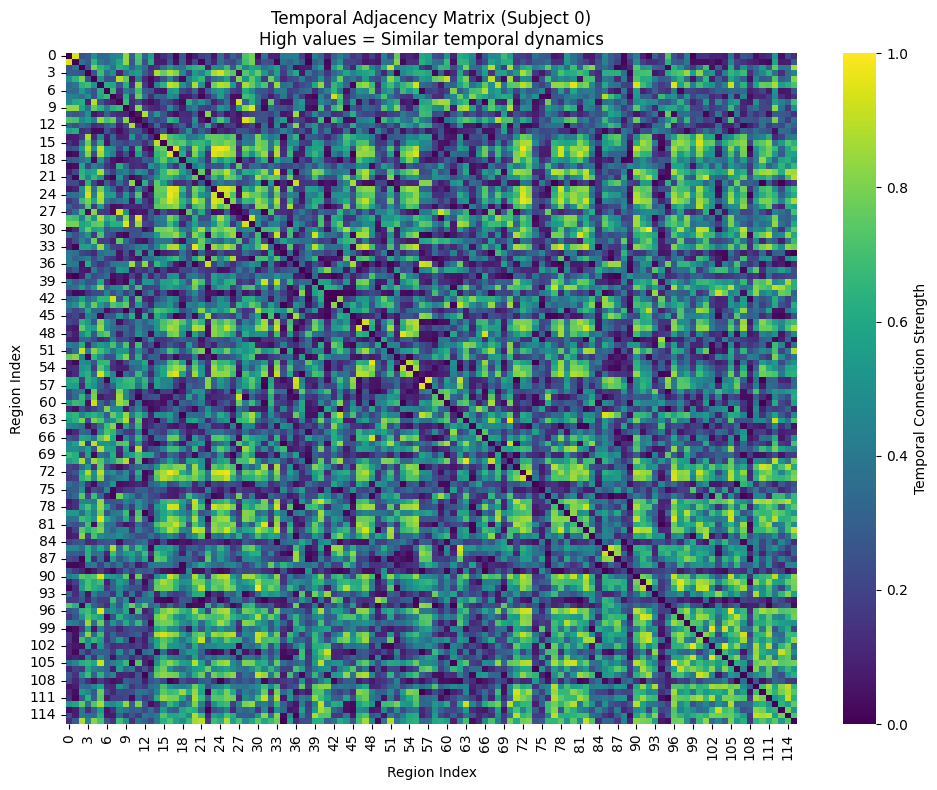

In [16]:
# Create temporal adjacency matrices with weighted values
def create_temporal_adjacency_weighted(interlayer_matrix):
    """
    Create weighted temporal adjacency matrix from interlayer correlations.
    High values indicate long-term connections, low values indicate short-term.
    
    Args:
        interlayer_matrix: Output from build_interlayer_adjacency (windows x regions)
    
    Returns:
        adjacency_matrix: regions x regions matrix with temporal connection weights
    """
    # Transpose to get regions x windows
    regions_windows = interlayer_matrix.T
    num_regions = regions_windows.shape[0]
    
    # Create adjacency matrix: regions x regions
    adjacency_matrix = np.zeros((num_regions, num_regions))
    
    # For each pair of regions, compute temporal similarity
    for i in range(num_regions):
        for j in range(num_regions):
            if i != j:  # No self-connections
                # Temporal profiles for regions i and j across windows
                profile_i = regions_windows[i, :]
                profile_j = regions_windows[j, :]
                
                # Compute correlation of temporal profiles
                # High correlation = both regions have similar temporal dynamics
                corr = np.corrcoef(profile_i, profile_j)[0, 1]
                
                # Handle NaN correlations (constant profiles)
                if np.isnan(corr):
                    weight = 0
                else:
                    # Use absolute correlation as edge weight
                    weight = np.abs(corr)
                
                adjacency_matrix[i, j] = weight
    
    return adjacency_matrix

# Create temporal adjacency matrices for all subjects
temporal_adjacency_matrices = []

for interlayer_matrix in interlayer_adjacency_matrices:
    temporal_adj = create_temporal_adjacency_weighted(interlayer_matrix)
    temporal_adjacency_matrices.append(temporal_adj)

print(f"Created temporal adjacency matrices for {len(temporal_adjacency_matrices)} subjects")
print(f"Matrix shape: {temporal_adjacency_matrices[0].shape}")
print(f"Value range: {np.min(temporal_adjacency_matrices[0]):.3f} to {np.max(temporal_adjacency_matrices[0]):.3f}")

# Visualize the temporal adjacency matrix for first subject
plt.figure(figsize=(10, 8))
sns.heatmap(temporal_adjacency_matrices[0], 
            cmap='viridis', 
            vmin=0, vmax=1,
            cbar_kws={'label': 'Temporal Connection Strength'})
plt.title("Temporal Adjacency Matrix (Subject 0)\nHigh values = Similar temporal dynamics")
plt.xlabel("Region Index")
plt.ylabel("Region Index")
plt.tight_layout()
plt.show()


In [18]:
# Step 1: Build Multilayer Graph Structure for Temporal Node2Vec
import random
from collections import defaultdict

class TemporalMultilayerGraph:
    """
    Multilayer graph structure for temporal-aware Node2Vec.
    Each node is represented as (roi_id, window_id).
    """
    def __init__(self, fc_matrices, temporal_adjacency_matrix):
        self.fc_matrices = fc_matrices  # List of FC matrices per window
        self.temporal_adj = temporal_adjacency_matrix  # Temporal connections between ROIs
        self.num_windows = len(fc_matrices)
        self.num_rois = fc_matrices[0].shape[0]
        
        # Build adjacency lists for efficient random walks
        self.intralayer_adj = self._build_intralayer_adjacency()
        self.interlayer_adj = self._build_interlayer_adjacency()
        
    def _build_intralayer_adjacency(self):
        """Build adjacency lists for intralayer connections (within time windows)"""
        intralayer_adj = defaultdict(list)
        
        for window in range(self.num_windows):
            fc_matrix = self.fc_matrices[window]
            
            for roi_i in range(self.num_rois):
                node_i = (roi_i, window)
                neighbors = []
                
                for roi_j in range(self.num_rois):
                    if roi_i != roi_j:  # No self-connections
                        weight = abs(fc_matrix.iloc[roi_i, roi_j])
                        if weight > 0:  # Only add if there's a connection
                            node_j = (roi_j, window)
                            neighbors.append((node_j, weight))
                
                # Sort by weight (higher weights first for probability sampling)
                neighbors.sort(key=lambda x: x[1], reverse=True)
                intralayer_adj[node_i] = neighbors
                
        return intralayer_adj
    
    def _build_interlayer_adjacency(self):
        """Build adjacency lists for interlayer connections (across time windows)"""
        interlayer_adj = defaultdict(list)
        
        for window in range(self.num_windows - 1):  # Can't jump from last window
            for roi in range(self.num_rois):
                current_node = (roi, window)
                next_node = (roi, window + 1)
                
                # Weight based on temporal stability of this ROI
                # Use the interlayer correlation we computed earlier
                weight = abs(self.temporal_adj[roi, roi]) if roi < self.temporal_adj.shape[0] else 0.1
                
                if weight > 0:
                    interlayer_adj[current_node] = [(next_node, weight)]
        
        # Also allow backward jumps
        for window in range(1, self.num_windows):
            for roi in range(self.num_rois):
                current_node = (roi, window)
                prev_node = (roi, window - 1)
                
                weight = abs(self.temporal_adj[roi, roi]) if roi < self.temporal_adj.shape[0] else 0.1
                
                if weight > 0:
                    if current_node not in interlayer_adj:
                        interlayer_adj[current_node] = []
                    interlayer_adj[current_node].append((prev_node, weight))
                
        return interlayer_adj
    
    def get_all_nodes(self):
        """Get all nodes in the multilayer graph"""
        nodes = []
        for window in range(self.num_windows):
            for roi in range(self.num_rois):
                nodes.append((roi, window))
        return nodes

# Build multilayer graphs for all subjects
multilayer_graphs = []

for subject_idx, (fc_matrices, temporal_adj) in enumerate(zip(subject_fc_matrices, temporal_adjacency_matrices)):
    print(subject_idx)
    graph = TemporalMultilayerGraph(fc_matrices, temporal_adj)
    multilayer_graphs.append(graph)
    
print(f"Built multilayer graphs for {len(multilayer_graphs)} subjects")
print(f"Each graph has {multilayer_graphs[0].num_rois * multilayer_graphs[0].num_windows} nodes")
print(f"Structure: {multilayer_graphs[0].num_rois} ROIs × {multilayer_graphs[0].num_windows} windows")

# Test the structure
test_graph = multilayer_graphs[0]
test_node = (0, 0)  # ROI 0, Window 0
print(f"\nTest node {test_node}:")
print(f"Intralayer neighbors: {len(test_graph.intralayer_adj[test_node])}")
print(f"Interlayer neighbors: {len(test_graph.interlayer_adj[test_node])}")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [19]:
# Step 2: Temporal-Aware Random Walk Implementation
import numpy as np

class TemporalRandomWalker:
    """
    Implements temporal-aware random walks for multilayer brain networks.
    Alternates between intralayer (spatial) and interlayer (temporal) jumps.
    """
    def __init__(self, graph, p_interlayer=0.3, p_return=1.0, q_explore=1.0):
        self.graph = graph
        self.p_interlayer = p_interlayer  # Probability of making interlayer jump
        self.p_return = p_return  # Return parameter (like in Node2Vec)
        self.q_explore = q_explore  # Exploration parameter (like in Node2Vec)
    
    def _weighted_choice(self, choices):
        """Choose a neighbor based on edge weights"""
        if not choices:
            return None
            
        weights = [weight for _, weight in choices]
        total = sum(weights)
        
        if total == 0:
            return random.choice(choices)[0] if choices else None
            
        # Normalize weights
        probabilities = [w/total for w in weights]
        
        # Random choice based on probabilities
        r = random.random()
        cumsum = 0
        for i, prob in enumerate(probabilities):
            cumsum += prob
            if r <= cumsum:
                return choices[i][0]
        
        return choices[-1][0]  # Fallback
    
    def _get_biased_neighbors(self, current_node, prev_node=None):
        """Get neighbors with Node2Vec-style biased sampling"""
        intralayer_neighbors = self.graph.intralayer_adj.get(current_node, [])
        
        if prev_node is None:
            return intralayer_neighbors
        
        # Apply p and q biases like in Node2Vec
        biased_neighbors = []
        
        for neighbor, weight in intralayer_neighbors:
            if neighbor == prev_node:
                # Return to previous node (distance = 0)
                biased_weight = weight / self.p_return
            else:
                # Check if neighbor was connected to previous node
                prev_neighbors = [n[0] for n in self.graph.intralayer_adj.get(prev_node, [])]
                if neighbor in prev_neighbors:
                    # Distance = 1 (common neighbor)
                    biased_weight = weight
                else:
                    # Distance = 2 (exploration)
                    biased_weight = weight / self.q_explore
            
            biased_neighbors.append((neighbor, biased_weight))
        
        return biased_neighbors
    
    def generate_walk(self, start_node, walk_length=80):
        """
        Generate a single random walk starting from start_node.
        Alternates between intralayer and interlayer jumps.
        """
        walk = [start_node]
        current_node = start_node
        prev_node = None
        
        for step in range(walk_length - 1):
            # Decide: intralayer or interlayer jump?
            make_interlayer_jump = (random.random() < self.p_interlayer and 
                                  current_node in self.graph.interlayer_adj)
            
            if make_interlayer_jump:
                # INTERLAYER JUMP: Move to same ROI in different time window
                interlayer_neighbors = self.graph.interlayer_adj[current_node]
                next_node = self._weighted_choice(interlayer_neighbors)
                
                if next_node is None:
                    # Fallback to intralayer if no interlayer connections
                    make_interlayer_jump = False
            
            if not make_interlayer_jump:
                # INTRALAYER JUMP: Move to different ROI in same time window
                intralayer_neighbors = self._get_biased_neighbors(current_node, prev_node)
                next_node = self._weighted_choice(intralayer_neighbors)
            
            # If we can't move anywhere, stop the walk
            if next_node is None:
                break
            
            walk.append(next_node)
            prev_node = current_node
            current_node = next_node
        
        return walk
    
    def generate_walks(self, num_walks=10, walk_length=80, verbose=True):
        """Generate multiple random walks from all nodes"""
        all_walks = []
        all_nodes = self.graph.get_all_nodes()
        
        for walk_num in range(num_walks):
            if verbose and walk_num % 5 == 0:
                print(f"Generating walk batch {walk_num + 1}/{num_walks}")
            
            # Shuffle nodes for each walk iteration
            random.shuffle(all_nodes)
            
            for start_node in all_nodes:
                walk = self.generate_walk(start_node, walk_length)
                if len(walk) > 1:  # Only keep walks with at least 2 nodes
                    all_walks.append(walk)
        
        return all_walks

# Generate temporal-aware random walks for all subjects
print("Generating temporal-aware random walks...")

subject_walks = []
walk_params = {
    'num_walks': 10,
    'walk_length': 80,
    'p_interlayer': 0.3,  # 30% chance of temporal jump
    'p_return': 1.0,      # Node2Vec return parameter
    'q_explore': 2.0      # Node2Vec exploration parameter
}

for subject_idx, graph in enumerate(multilayer_graphs[:3]):  # Test with first 3 subjects
    print(f"\nSubject {subject_idx + 1}:")
    
    walker = TemporalRandomWalker(
        graph, 
        p_interlayer=walk_params['p_interlayer'],
        p_return=walk_params['p_return'],
        q_explore=walk_params['q_explore']
    )
    
    walks = walker.generate_walks(
        num_walks=walk_params['num_walks'],
        walk_length=walk_params['walk_length'],
        verbose=True
    )
    
    subject_walks.append(walks)
    print(f"Generated {len(walks)} walks")
    
    # Show sample walk
    if walks:
        sample_walk = walks[0][:10]  # First 10 steps
        print(f"Sample walk: {sample_walk}")

print(f"\nTotal walks generated: {sum(len(walks) for walks in subject_walks)}")


Generating temporal-aware random walks...

Subject 1:
Generating walk batch 1/10
Generating walk batch 6/10
Generated 12760 walks
Sample walk: [(17, 10), (35, 10), (109, 10), (97, 10), (115, 10), (62, 10), (59, 10), (57, 10), (36, 10), (6, 10)]

Subject 2:
Generating walk batch 1/10
Generating walk batch 6/10
Generated 12650 walks
Sample walk: [(65, 5), (84, 5), (14, 5), (59, 5), (2, 5), (44, 5), (96, 5), (105, 5), (2, 5), (102, 5)]

Subject 3:
Generating walk batch 1/10
Generating walk batch 6/10
Generated 12320 walks
Sample walk: [(83, 7), (11, 7), (57, 7), (96, 7), (78, 7), (49, 7), (104, 7), (23, 7), (16, 7), (52, 7)]

Total walks generated: 37730


In [28]:
# Step 3: Node2Vec Embedding Generation
from gensim.models import Word2Vec
import pickle

class TemporalNode2Vec:
    """
    Generates node embeddings from temporal-aware random walks.
    Uses Word2Vec to learn embeddings where temporally stable ROIs are closer.
    """
    def __init__(self, dimensions=128, window_size=10, min_count=1, workers=4):
        self.dimensions = dimensions
        self.window_size = window_size
        self.min_count = min_count
        self.workers = workers
        self.model = None
        
    def fit(self, walks):
        """Train Word2Vec model on random walks"""
        # Convert walks to string format for Word2Vec
        string_walks = []
        for walk in walks:
            string_walk = [f"{roi}_{window}" for roi, window in walk]
            string_walks.append(string_walk)
        
        print(f"Training Word2Vec on {len(string_walks)} walks...")
        
        # Train Word2Vec model
        self.model = Word2Vec(
            sentences=string_walks,
            vector_size=self.dimensions,
            window=self.window_size,
            min_count=self.min_count,
            workers=self.workers,
            sg=1,  # Skip-gram (like Node2Vec)
            hs=0,  # Negative sampling
            negative=10,
            epochs=20
        )
        
        print(f"Model vocabulary size: {len(self.model.wv.index_to_key)}")
        return self
    
    def get_node_embedding(self, roi, window):
        """Get embedding for a specific (roi, window) node"""
        node_string = f"{roi}_{window}"
        if node_string in self.model.wv:
            return self.model.wv[node_string]
        else:
            return np.zeros(self.dimensions)
    
    def get_roi_embedding(self, roi, aggregation='mean'):
        """
        Get aggregated embedding for an ROI across all time windows.
        This represents the temporal-aware embedding of the brain region.
        """
        embeddings = []
        
        for window in range(11):  # We have 11 time windows
            embedding = self.get_node_embedding(roi, window)
            if not np.allclose(embedding, 0):  # Skip zero embeddings
                embeddings.append(embedding)
        
        if not embeddings:
            return np.zeros(self.dimensions)
        
        embeddings = np.array(embeddings)
        
        if aggregation == 'mean':
            return np.mean(embeddings, axis=0)
        elif aggregation == 'max':
            return np.max(embeddings, axis=0)
        elif aggregation == 'concatenate':
            return embeddings.flatten()
        else:
            raise ValueError("aggregation must be 'mean', 'max', or 'concatenate'")
    
    def get_subject_embedding_matrix(self, num_rois=116):
        """
        Get the final embedding matrix for a subject.
        Shape: (num_rois, embedding_dimensions)
        """
        embedding_matrix = np.zeros((num_rois, self.dimensions))
        
        for roi in range(num_rois):
            embedding_matrix[roi] = self.get_roi_embedding(roi)
        
        return embedding_matrix

# Generate embeddings for each subject
print("Generating temporal node embeddings...")

subject_embeddings = []
embedding_params = {
    'dimensions': 128,
    'window_size': 10,
    'min_count': 1,
    'workers': 4
}

for subject_idx, walks in enumerate(subject_walks):
    print(f"\nSubject {subject_idx + 1}:")
    
    # Train temporal Node2Vec
    temporal_node2vec = TemporalNode2Vec(**embedding_params)
    temporal_node2vec.fit(walks)
    
    # Get final embedding matrix for this subject
    embedding_matrix = temporal_node2vec.get_subject_embedding_matrix()
    subject_embeddings.append(embedding_matrix)
    
    print(f"Generated embedding matrix shape: {embedding_matrix.shape}")
    
    # Show some statistics
    mean_embedding_norm = np.mean(np.linalg.norm(embedding_matrix, axis=1))
    print(f"Mean embedding norm: {mean_embedding_norm:.3f}")

print(f"\nGenerated embeddings for {len(subject_embeddings)} subjects")
print(f"Each subject embedding matrix shape: {subject_embeddings[0].shape}")

# Visualize embedding similarity for first subject
if subject_embeddings:
    embedding_matrix = subject_embeddings[0]
    
    # Compute pairwise cosine similarities between ROI embeddings
    from sklearn.metrics.pairwise import cosine_similarity
    
    roi_similarities = cosine_similarity(embedding_matrix)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(roi_similarities, 
                cmap='viridis', 
                vmin=-1, vmax=1,
                cbar_kws={'label': 'Cosine Similarity'})
    plt.title("ROI Embedding Similarities (Subject 1)\nHigh values = Similar temporal dynamics")
    plt.xlabel("ROI Index")
    plt.ylabel("ROI Index")
    plt.tight_layout()
    plt.show()
    
    print(f"Embedding similarity range: {roi_similarities.min():.3f} to {roi_similarities.max():.3f}")


ModuleNotFoundError: No module named 'gensim'

In [ ]:
# Visualization 1: Multilayer Graph Structure Analysis
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_multilayer_graph_structure(graph, subject_idx=0):
    """Analyze and visualize the multilayer graph structure"""
    
    print(f"=== MULTILAYER GRAPH ANALYSIS (Subject {subject_idx + 1}) ===\n")
    
    # 1. Basic statistics
    all_nodes = graph.get_all_nodes()
    total_intralayer_edges = sum(len(neighbors) for neighbors in graph.intralayer_adj.values())
    total_interlayer_edges = sum(len(neighbors) for neighbors in graph.interlayer_adj.values())
    
    print(f"📊 Graph Statistics:")
    print(f"   • Total nodes: {len(all_nodes)} ({graph.num_rois} ROIs × {graph.num_windows} windows)")
    print(f"   • Intralayer edges: {total_intralayer_edges:,}")
    print(f"   • Interlayer edges: {total_interlayer_edges:,}")
    print(f"   • Edge ratio (inter/intra): {total_interlayer_edges/total_intralayer_edges:.3f}")
    
    # 2. Connectivity distribution per layer
    layer_connectivity = []
    for window in range(graph.num_windows):
        layer_edges = 0
        for roi in range(graph.num_rois):
            node = (roi, window)
            layer_edges += len(graph.intralayer_adj.get(node, []))
        layer_connectivity.append(layer_edges)
    
    # 3. Temporal connectivity strength
    temporal_strengths = []
    for roi in range(graph.num_rois):
        roi_temporal_strength = 0
        roi_temporal_count = 0
        for window in range(graph.num_windows):
            node = (roi, window)
            if node in graph.interlayer_adj:
                for _, weight in graph.interlayer_adj[node]:
                    roi_temporal_strength += weight
                    roi_temporal_count += 1
        
        avg_strength = roi_temporal_strength / roi_temporal_count if roi_temporal_count > 0 else 0
        temporal_strengths.append(avg_strength)
    
    # 4. Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Connectivity per time window
    axes[0, 0].bar(range(graph.num_windows), layer_connectivity, color='skyblue', alpha=0.7)
    axes[0, 0].set_title('Intralayer Connectivity per Time Window')
    axes[0, 0].set_xlabel('Time Window')
    axes[0, 0].set_ylabel('Number of Edges')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Temporal strength distribution
    axes[0, 1].hist(temporal_strengths, bins=30, color='lightcoral', alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Distribution of ROI Temporal Stability')
    axes[0, 1].set_xlabel('Average Temporal Connection Strength')
    axes[0, 1].set_ylabel('Number of ROIs')
    axes[0, 1].axvline(np.mean(temporal_strengths), color='red', linestyle='--', 
                       label=f'Mean: {np.mean(temporal_strengths):.3f}')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Sample FC matrix (first window)
    fc_sample = graph.fc_matrices[0]
    im1 = axes[1, 0].imshow(fc_sample, cmap='coolwarm', vmin=-1, vmax=1)
    axes[1, 0].set_title('Sample FC Matrix (Window 0)')
    axes[1, 0].set_xlabel('ROI Index')
    axes[1, 0].set_ylabel('ROI Index')
    plt.colorbar(im1, ax=axes[1, 0])
    
    # Plot 4: Temporal adjacency matrix
    im2 = axes[1, 1].imshow(graph.temporal_adj, cmap='viridis', vmin=0, vmax=1)
    axes[1, 1].set_title('Temporal Adjacency Matrix')
    axes[1, 1].set_xlabel('ROI Index')
    axes[1, 1].set_ylabel('ROI Index')
    plt.colorbar(im2, ax=axes[1, 1])
    
    plt.tight_layout()
    plt.show()
    
    # 5. ROI connectivity rankings
    print(f"\n🔗 Top 10 Most Temporally Stable ROIs:")
    roi_stability_ranking = [(roi, strength) for roi, strength in enumerate(temporal_strengths)]
    roi_stability_ranking.sort(key=lambda x: x[1], reverse=True)
    
    for i, (roi, strength) in enumerate(roi_stability_ranking[:10]):
        print(f"   {i+1:2d}. ROI {roi:3d}: {strength:.4f}")
    
    print(f"\n🔗 Top 10 Least Temporally Stable ROIs:")
    for i, (roi, strength) in enumerate(roi_stability_ranking[-10:]):
        print(f"   {i+1:2d}. ROI {roi:3d}: {strength:.4f}")
    
    return {
        'layer_connectivity': layer_connectivity,
        'temporal_strengths': temporal_strengths,
        'total_intralayer_edges': total_intralayer_edges,
        'total_interlayer_edges': total_interlayer_edges
    }

# Analyze the first subject's multilayer graph
if multilayer_graphs:
    graph_stats = analyze_multilayer_graph_structure(multilayer_graphs[0], subject_idx=0)


In [ ]:
# Visualization 2: Random Walk Analysis
def analyze_random_walks(walks, subject_idx=0):
    """Analyze and visualize the random walk patterns"""
    
    print(f"=== RANDOM WALK ANALYSIS (Subject {subject_idx + 1}) ===\n")
    
    # 1. Basic walk statistics
    walk_lengths = [len(walk) for walk in walks]
    total_steps = sum(walk_lengths)
    
    print(f"🚶 Walk Statistics:")
    print(f"   • Total walks: {len(walks):,}")
    print(f"   • Total steps: {total_steps:,}")
    print(f"   • Avg walk length: {np.mean(walk_lengths):.1f}")
    print(f"   • Walk length range: {min(walk_lengths)} - {max(walk_lengths)}")
    
    # 2. Analyze jump types (intralayer vs interlayer)
    intralayer_jumps = 0
    interlayer_jumps = 0
    window_transitions = []
    roi_transitions = []
    
    for walk in walks:
        for i in range(len(walk) - 1):
            current_roi, current_window = walk[i]
            next_roi, next_window = walk[i + 1]
            
            if current_window == next_window:
                # Intralayer jump (same window, different ROI)
                intralayer_jumps += 1
                roi_transitions.append(abs(next_roi - current_roi))
            else:
                # Interlayer jump (same ROI, different window)
                interlayer_jumps += 1
                window_transitions.append(abs(next_window - current_window))
    
    total_jumps = intralayer_jumps + interlayer_jumps
    intralayer_ratio = intralayer_jumps / total_jumps if total_jumps > 0 else 0
    interlayer_ratio = interlayer_jumps / total_jumps if total_jumps > 0 else 0
    
    print(f"\n🔄 Jump Type Analysis:")
    print(f"   • Intralayer jumps: {intralayer_jumps:,} ({intralayer_ratio:.1%})")
    print(f"   • Interlayer jumps: {interlayer_jumps:,} ({interlayer_ratio:.1%})")
    print(f"   • Total transitions: {total_jumps:,}")
    
    # 3. ROI visitation frequency
    roi_visits = defaultdict(int)
    window_visits = defaultdict(int)
    
    for walk in walks:
        for roi, window in walk:
            roi_visits[roi] += 1
            window_visits[window] += 1
    
    most_visited_rois = sorted(roi_visits.items(), key=lambda x: x[1], reverse=True)
    most_visited_windows = sorted(window_visits.items(), key=lambda x: x[1], reverse=True)
    
    # 4. Create visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Plot 1: Walk length distribution
    axes[0, 0].hist(walk_lengths, bins=30, color='lightblue', alpha=0.7, edgecolor='black')
    axes[0, 0].set_title('Distribution of Walk Lengths')
    axes[0, 0].set_xlabel('Walk Length')
    axes[0, 0].set_ylabel('Number of Walks')
    axes[0, 0].axvline(np.mean(walk_lengths), color='red', linestyle='--', 
                       label=f'Mean: {np.mean(walk_lengths):.1f}')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Jump type ratio
    jump_types = ['Intralayer\\n(Spatial)', 'Interlayer\\n(Temporal)']
    jump_counts = [intralayer_jumps, interlayer_jumps]
    colors = ['lightcoral', 'lightgreen']
    
    wedges, texts, autotexts = axes[0, 1].pie(jump_counts, labels=jump_types, colors=colors, 
                                              autopct='%1.1f%%', startangle=90)
    axes[0, 1].set_title('Jump Type Distribution')
    
    # Plot 3: ROI transition distances (for intralayer jumps)
    if roi_transitions:
        axes[0, 2].hist(roi_transitions, bins=range(0, max(roi_transitions)+2), 
                        color='orange', alpha=0.7, edgecolor='black')
        axes[0, 2].set_title('ROI Transition Distances\\n(Intralayer Jumps)')
        axes[0, 2].set_xlabel('ROI Distance')
        axes[0, 2].set_ylabel('Number of Jumps')
        axes[0, 2].grid(True, alpha=0.3)
    
    # Plot 4: ROI visitation frequency
    roi_ids = list(range(len(roi_visits)))
    roi_counts = [roi_visits.get(roi, 0) for roi in roi_ids]
    
    axes[1, 0].bar(roi_ids[::5], roi_counts[::5], color='purple', alpha=0.7)  # Sample every 5th ROI
    axes[1, 0].set_title('ROI Visitation Frequency\\n(Every 5th ROI)')
    axes[1, 0].set_xlabel('ROI Index')
    axes[1, 0].set_ylabel('Visit Count')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 5: Window visitation frequency
    window_ids = list(window_visits.keys())
    window_counts = list(window_visits.values())
    
    axes[1, 1].bar(window_ids, window_counts, color='teal', alpha=0.7)
    axes[1, 1].set_title('Time Window Visitation Frequency')
    axes[1, 1].set_xlabel('Time Window')
    axes[1, 1].set_ylabel('Visit Count')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Plot 6: Sample walk visualization
    if walks:
        sample_walk = walks[0][:20]  # First 20 steps of first walk
        rois = [roi for roi, window in sample_walk]
        windows = [window for roi, window in sample_walk]
        
        axes[1, 2].scatter(range(len(sample_walk)), rois, c=windows, 
                          cmap='viridis', s=50, alpha=0.8)
        axes[1, 2].plot(range(len(sample_walk)), rois, alpha=0.5, color='gray')
        axes[1, 2].set_title('Sample Walk Trajectory\\n(First 20 Steps)')
        axes[1, 2].set_xlabel('Step')
        axes[1, 2].set_ylabel('ROI Index')
        axes[1, 2].grid(True, alpha=0.3)
        
        # Add colorbar for time windows
        cbar = plt.colorbar(axes[1, 2].scatter(range(len(sample_walk)), rois, c=windows, 
                                              cmap='viridis', s=0), ax=axes[1, 2])
        cbar.set_label('Time Window')
    
    plt.tight_layout()
    plt.show()
    
    # 5. Top visited ROIs and windows
    print(f"\n🎯 Top 10 Most Visited ROIs:")
    for i, (roi, count) in enumerate(most_visited_rois[:10]):
        print(f"   {i+1:2d}. ROI {roi:3d}: {count:,} visits")
    
    print(f"\n⏰ Window Visit Distribution:")
    for window, count in most_visited_windows:
        print(f"   Window {window}: {count:,} visits")
    
    return {
        'intralayer_jumps': intralayer_jumps,
        'interlayer_jumps': interlayer_jumps,
        'walk_lengths': walk_lengths,
        'roi_visits': dict(roi_visits),
        'window_visits': dict(window_visits)
    }

# Analyze random walks for the first subject
if subject_walks:
    walk_stats = analyze_random_walks(subject_walks[0], subject_idx=0)


In [ ]:
# Visualization 3: Node Embedding Analysis
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

def analyze_node_embeddings(embedding_matrix, subject_idx=0, temporal_adj_matrix=None):
    """Analyze and visualize the generated node embeddings"""
    
    print(f"=== NODE EMBEDDING ANALYSIS (Subject {subject_idx + 1}) ===\n")
    
    # 1. Basic embedding statistics
    num_rois, embedding_dim = embedding_matrix.shape
    embedding_norms = np.linalg.norm(embedding_matrix, axis=1)
    
    print(f"🎯 Embedding Statistics:")
    print(f"   • Matrix shape: {embedding_matrix.shape}")
    print(f"   • Embedding dimensions: {embedding_dim}")
    print(f"   • Number of ROIs: {num_rois}")
    print(f"   • Mean embedding norm: {np.mean(embedding_norms):.3f}")
    print(f"   • Std embedding norm: {np.std(embedding_norms):.3f}")
    print(f"   • Norm range: {np.min(embedding_norms):.3f} - {np.max(embedding_norms):.3f}")
    
    # 2. Compute embedding similarities
    embedding_similarities = cosine_similarity(embedding_matrix)
    
    # Remove diagonal (self-similarities)
    similarity_values = embedding_similarities[np.triu_indices_from(embedding_similarities, k=1)]
    
    print(f"\n🔍 Embedding Similarity Analysis:")
    print(f"   • Mean similarity: {np.mean(similarity_values):.3f}")
    print(f"   • Std similarity: {np.std(similarity_values):.3f}")
    print(f"   • Similarity range: {np.min(similarity_values):.3f} - {np.max(similarity_values):.3f}")
    
    # 3. Find most and least similar ROI pairs
    similarity_pairs = []
    for i in range(num_rois):
        for j in range(i+1, num_rois):
            similarity_pairs.append((i, j, embedding_similarities[i, j]))
    
    similarity_pairs.sort(key=lambda x: x[2], reverse=True)
    
    # 4. Dimensionality reduction for visualization
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embedding_matrix)
    
    # 5. Clustering analysis
    n_clusters = 8
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embedding_matrix)
    
    # 6. Create visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Plot 1: Embedding norm distribution
    axes[0, 0].hist(embedding_norms, bins=30, color='lightblue', alpha=0.7, edgecolor='black')
    axes[0, 0].set_title('Distribution of Embedding Norms')
    axes[0, 0].set_xlabel('Embedding Norm')
    axes[0, 0].set_ylabel('Number of ROIs')
    axes[0, 0].axvline(np.mean(embedding_norms), color='red', linestyle='--', 
                       label=f'Mean: {np.mean(embedding_norms):.3f}')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Similarity distribution
    axes[0, 1].hist(similarity_values, bins=50, color='lightcoral', alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Distribution of Pairwise Similarities')
    axes[0, 1].set_xlabel('Cosine Similarity')
    axes[0, 1].set_ylabel('Number of ROI Pairs')
    axes[0, 1].axvline(np.mean(similarity_values), color='red', linestyle='--', 
                       label=f'Mean: {np.mean(similarity_values):.3f}')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: PCA visualization
    scatter = axes[0, 2].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                                c=cluster_labels, cmap='tab10', s=50, alpha=0.7)
    axes[0, 2].set_title('ROI Embeddings (PCA Projection)')
    axes[0, 2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    axes[0, 2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    axes[0, 2].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[0, 2], label='Cluster')
    
    # Plot 4: Full similarity matrix
    im1 = axes[1, 0].imshow(embedding_similarities, cmap='viridis', vmin=-1, vmax=1)
    axes[1, 0].set_title('ROI Embedding Similarity Matrix')
    axes[1, 0].set_xlabel('ROI Index')
    axes[1, 0].set_ylabel('ROI Index')
    plt.colorbar(im1, ax=axes[1, 0])
    
    # Plot 5: Embedding vs Temporal correlation (if available)
    if temporal_adj_matrix is not None:
        temporal_similarities = []
        embedding_sims = []
        
        for i in range(num_rois):
            for j in range(i+1, num_rois):
                temporal_similarities.append(temporal_adj_matrix[i, j])
                embedding_sims.append(embedding_similarities[i, j])
        
        axes[1, 1].scatter(temporal_similarities, embedding_sims, alpha=0.6, s=20)
        axes[1, 1].set_title('Embedding vs Temporal Similarity')
        axes[1, 1].set_xlabel('Temporal Adjacency Weight')
        axes[1, 1].set_ylabel('Embedding Cosine Similarity')
        axes[1, 1].grid(True, alpha=0.3)
        
        # Add correlation coefficient
        correlation = np.corrcoef(temporal_similarities, embedding_sims)[0, 1]
                 axes[1, 1].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                         transform=axes[1, 1].transAxes, fontsize=10,
                         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Plot 6: Cluster sizes\n    cluster_counts = np.bincount(cluster_labels)\n    axes[1, 2].bar(range(n_clusters), cluster_counts, color='lightgreen', alpha=0.7)\n    axes[1, 2].set_title('ROI Cluster Sizes')\n    axes[1, 2].set_xlabel('Cluster ID')\n    axes[1, 2].set_ylabel('Number of ROIs')\n    axes[1, 2].grid(True, alpha=0.3)\n    \n    plt.tight_layout()\n    plt.show()\n    \n    # 7. Most similar ROI pairs\n    print(f\"\\n🤝 Top 10 Most Similar ROI Pairs:\")\n    for i, (roi1, roi2, sim) in enumerate(similarity_pairs[:10]):\n        print(f\"   {i+1:2d}. ROI {roi1:3d} ↔ ROI {roi2:3d}: {sim:.4f}\")\n    \n    print(f\"\\n🚫 Top 10 Least Similar ROI Pairs:\")\n    for i, (roi1, roi2, sim) in enumerate(similarity_pairs[-10:]):\n        print(f\"   {i+1:2d}. ROI {roi1:3d} ↔ ROI {roi2:3d}: {sim:.4f}\")\n    \n    # 8. Cluster analysis\n    print(f\"\\n🎯 Cluster Analysis ({n_clusters} clusters):\")\n    for cluster_id in range(n_clusters):\n        cluster_rois = np.where(cluster_labels == cluster_id)[0]\n        print(f\"   Cluster {cluster_id}: {len(cluster_rois)} ROIs - {list(cluster_rois[:10])}{'...' if len(cluster_rois) > 10 else ''}\")\n    \n    return {\n        'embedding_similarities': embedding_similarities,\n        'similarity_pairs': similarity_pairs,\n        'cluster_labels': cluster_labels,\n        'embeddings_2d': embeddings_2d,\n        'embedding_norms': embedding_norms\n    }\n\n# Analyze embeddings for the first subject\nif subject_embeddings:\n    temporal_adj = temporal_adjacency_matrices[0] if temporal_adjacency_matrices else None\n    embedding_stats = analyze_node_embeddings(subject_embeddings[0], \n                                            subject_idx=0, \n                                            temporal_adj_matrix=temporal_adj)"


In [ ]:
# Clean Visualization 3: Node Embedding Analysis
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def analyze_embeddings_clean(embedding_matrix, subject_idx=0):
    """Clean analysis of node embeddings with comprehensive visualizations"""
    
    print(f"=== NODE EMBEDDING ANALYSIS (Subject {subject_idx + 1}) ===")
    
    # Basic stats
    num_rois, embedding_dim = embedding_matrix.shape
    embedding_norms = np.linalg.norm(embedding_matrix, axis=1)
    embedding_similarities = cosine_similarity(embedding_matrix)
    
    print(f"📊 Shape: {embedding_matrix.shape}")
    print(f"📊 Mean norm: {np.mean(embedding_norms):.3f}")
    print(f"📊 Mean similarity: {np.mean(embedding_similarities[np.triu_indices(num_rois, k=1)]):.3f}")
    
    # Create 6-panel visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # 1. Embedding norms
    axes[0, 0].hist(embedding_norms, bins=20, alpha=0.7, color='skyblue')
    axes[0, 0].set_title('Embedding Norm Distribution')
    axes[0, 0].set_xlabel('Norm')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Similarity matrix
    im1 = axes[0, 1].imshow(embedding_similarities, cmap='viridis')
    axes[0, 1].set_title('ROI Similarity Matrix')
    plt.colorbar(im1, ax=axes[0, 1])
    
    # 3. PCA projection
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embedding_matrix)
    
    kmeans = KMeans(n_clusters=6, random_state=42)
    clusters = kmeans.fit_predict(embedding_matrix)
    
    scatter = axes[0, 2].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                                c=clusters, cmap='tab10', alpha=0.7)
    axes[0, 2].set_title('PCA Projection (Colored by Clusters)')
    axes[0, 2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    axes[0, 2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    plt.colorbar(scatter, ax=axes[0, 2])
    
    # 4. Similarity distribution
    sim_values = embedding_similarities[np.triu_indices(num_rois, k=1)]
    axes[1, 0].hist(sim_values, bins=30, alpha=0.7, color='lightcoral')
    axes[1, 0].set_title('Pairwise Similarity Distribution')
    axes[1, 0].set_xlabel('Cosine Similarity')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Cluster sizes
    cluster_counts = np.bincount(clusters)
    axes[1, 1].bar(range(len(cluster_counts)), cluster_counts, alpha=0.7, color='lightgreen')
    axes[1, 1].set_title('Cluster Sizes')
    axes[1, 1].set_xlabel('Cluster ID')
    axes[1, 1].set_ylabel('Number of ROIs')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Top similar pairs
    similarity_pairs = []
    for i in range(num_rois):
        for j in range(i+1, num_rois):
            similarity_pairs.append((i, j, embedding_similarities[i, j]))
    
    similarity_pairs.sort(key=lambda x: x[2], reverse=True)
    
    top_pairs = similarity_pairs[:10]
    pair_labels = [f"ROI{p[0]}-ROI{p[1]}" for p in top_pairs]
    pair_sims = [p[2] for p in top_pairs]
    
    axes[1, 2].barh(range(len(top_pairs)), pair_sims, alpha=0.7, color='orange')
    axes[1, 2].set_yticks(range(len(top_pairs)))
    axes[1, 2].set_yticklabels(pair_labels, fontsize=8)
    axes[1, 2].set_title('Top 10 Most Similar ROI Pairs')
    axes[1, 2].set_xlabel('Cosine Similarity')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n🎯 Most similar pair: ROI {top_pairs[0][0]} ↔ ROI {top_pairs[0][1]} ({top_pairs[0][2]:.4f})")
    print(f"🎯 Least similar pair: ROI {similarity_pairs[-1][0]} ↔ ROI {similarity_pairs[-1][1]} ({similarity_pairs[-1][2]:.4f})")
    
    return embedding_similarities, clusters

# Run clean analysis on first subject
if subject_embeddings:
    embedding_sim, clusters = analyze_embeddings_clean(subject_embeddings[0], 0)
